## American Airlines - Mobile App Reviews EDA & Text Analysis
The data is a sample of reviews taken from American Airlines mobile app reviews from the Apple app store. The first dataframe uses data scraped no earlier than January 1st, 2019.

* Helpful tSNE article: https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751

In [218]:
import sys
import numpy as np
import pandas as pd
import time
import json
import datetime as dt
from pprint import pprint
from adjustText import adjust_text

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import plotly.express as px

from gensim.parsing.porter import PorterStemmer
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from sklearn.manifold import TSNE

from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore, CoherenceModel
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from itertools import chain


import warnings
warnings.filterwarnings('ignore')

In [219]:
extra_stop_words = ['\n', '\t']

In [220]:
aa_df = pd.read_csv("americanairlinesreviews.csv")
aa_df.drop(columns=['Unnamed: 0'], inplace=True)

In [221]:
aa_df.head()

,username,review,isEdited,rating,title,date
0,marley_mae,I downloaded this app for my most recent trip ...,False,5,Very helpful!!,2021-08-28 19:20:58
1,slpoulos,The app is almost always very efficient.... bu...,False,5,Most things good but service reduction on flig...,2021-03-21 23:58:57
2,eubanks6703,Flight 805 from Cancun to phl... April 5 238pm...,False,1,Horrible experience with VeriFLY,2021-04-06 00:24:56
3,AnaKaluderovic,The worst air company. I am flying all the tim...,False,1,The worst airlines,2022-03-24 21:22:03
4,Swooshn1,"Terrible app, this isn’t very functional comp...",False,5,Terrible app,2019-01-19 16:46:17


First, let's explore the attributes outside of reviews. For instance, let's check for missing values and then look at some distributions.

In [222]:
aa_df['date'].min()

'2019-01-01 20:19:27'

In [223]:
aa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3646 entries, 0 to 3645
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   username  3646 non-null   object
 1   review    3646 non-null   object
 2   isEdited  3646 non-null   bool  
 3   rating    3646 non-null   int64 
 4   title     3646 non-null   object
 5   date      3646 non-null   object
dtypes: bool(1), int64(1), object(4)
memory usage: 146.1+ KB


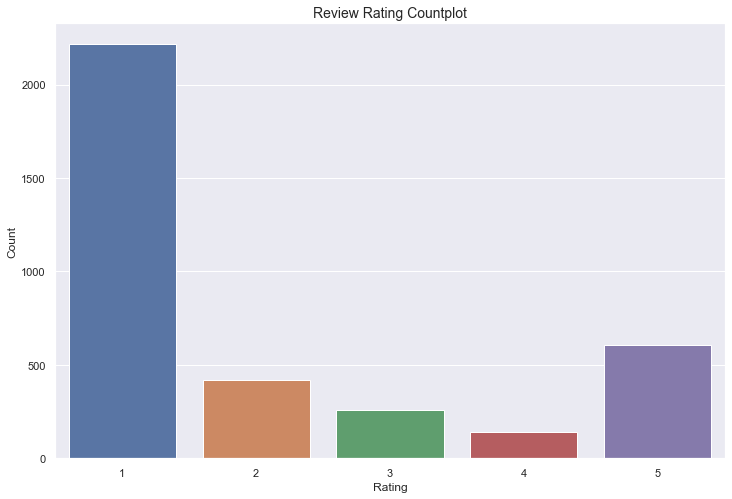

In [224]:
plt.figure(figsize=(12, 8))
g = sns.countplot(x='rating', data=aa_df)
g.set_title("Review Rating Countplot", fontsize=14)
g.set_xlabel("Rating")
g.set_ylabel("Count")
plt.show()

The average rating of all 230k+ reviews for this app on the app store is 4.6 (as of 5/27/2022). The sample of reviews that the scraper picked up here seems to pick up a lot of the very negative reviews. However, we can still utilize these reviews to view what issues customers are running into. We also need to be aware that rating as a potential target variable, is imbalanced.

Let's next look at the distribution of the lengths of the reviews.

In [225]:
aa_df['review_length'] = aa_df['review'].apply(len)

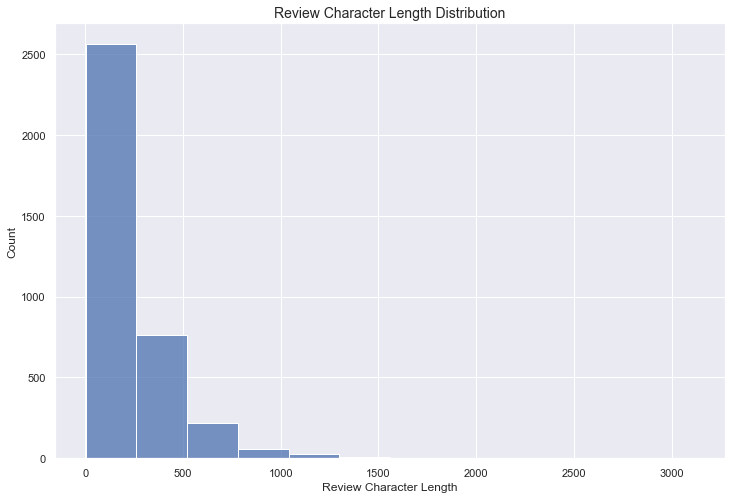

In [343]:
plt.figure(figsize=(12, 8))
g = sns.histplot(x='review_length', data=aa_df, bins=12)
g.set_title("Review Character Length Distribution", fontsize=14)
g.set_xlabel("Review Character Length")
g.set_ylabel("Count")
plt.show()

It appears we have some records that are even up to 3000 characters long. This will be important to know if we apply certain modeling techniques to this data.

In [227]:
aa_df.describe()

,rating,review_length
count,3646.000000,3646.000000
mean,2.040592,228.453922
std,1.527255,235.997960
min,1.000000,1.000000
25%,1.000000,83.000000
50%,1.000000,162.000000
75%,3.000000,294.000000
max,5.000000,3117.000000


In [228]:
aa_df['year_month'] = pd.to_datetime(aa_df['date']).dt.to_period('M')

In [229]:
df_counts = aa_df.groupby(['year_month']).agg({'review':'count'})
df_counts.head()

,review
year_month,
2019-01,89
2019-02,79
2019-03,74
2019-04,92
2019-05,85


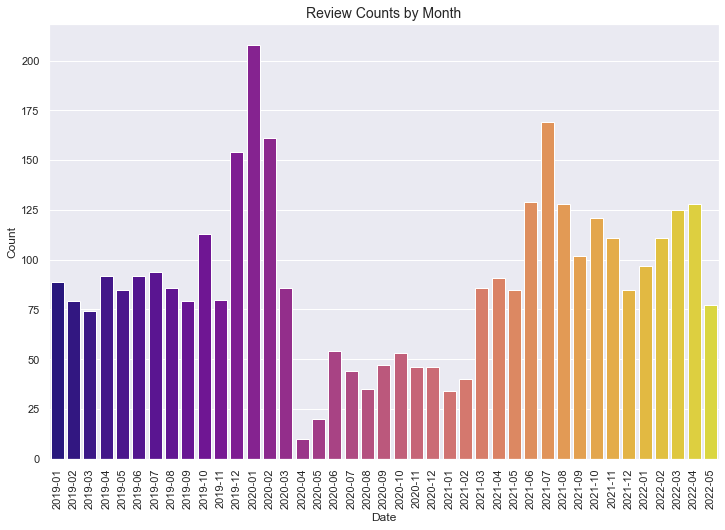

In [230]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=df_counts.index, y='review', data=df_counts, palette='plasma')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_title("Review Counts by Month", fontsize=14)
ax.set_xlabel("Date")
ax.set_ylabel("Count")
plt.show()

The amount of reviews dips after the 1st quarter of 2020. This could be due to the COVID-19 pandemic.

Now, when creating models, so that similar words with similar contexts can be mapped together, I would like to use the word2vec appraoch with these reviews.

### Tokenizing Reviews

In [141]:
porter_stemmer = PorterStemmer()

In [142]:
tokenized_reviews = [nltk.word_tokenize(rev.lower()) for rev in aa_df['review']]

In [154]:
tokenized_words = [[word for word in rev if word.isalnum() and word not in stop_words] for rev in tokenized_reviews]

In [163]:
words = np.concatenate(tokenized_words, axis=0)

In [144]:
#tokenized_words = [[porter_stemmer.stem(word) for word in rev] for rev in tokenized_reviews]

In [145]:
tokenized_reviews = pd.Series(tokenized_reviews)

### N-Gram Analysis
Using tokenized words, we get a quick glimpse of common phrases in the data by applying N-gram analysis.

In [188]:

bi_grams = Counter(chain(*[nltk.ngrams(sentence, 2) for sentence in tokenized_words]))


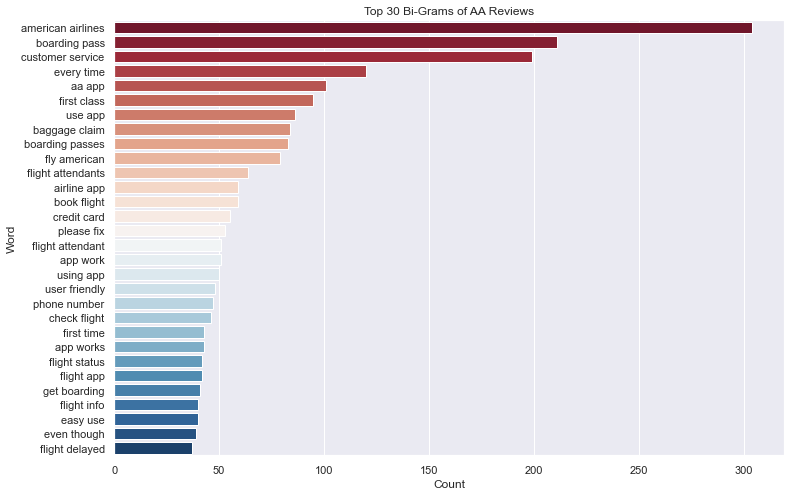

In [189]:
bi_gram_counts = bi_grams.most_common(30)

words = [' '.join(tup[0]) for tup in bi_gram_counts]
counts = [tup[1] for tup in bi_gram_counts]

plt.figure(figsize=(12,8))
g = sns.barplot(x=counts, y=words, palette='RdBu')
g.set_title('Top 30 Bi-Grams of AA Reviews')
g.set_xlabel('Count')
g.set_ylabel('Word')
plt.show(g)

In [190]:

tri_grams = Counter(chain(*[nltk.ngrams(sentence, 3) for sentence in tokenized_words]))


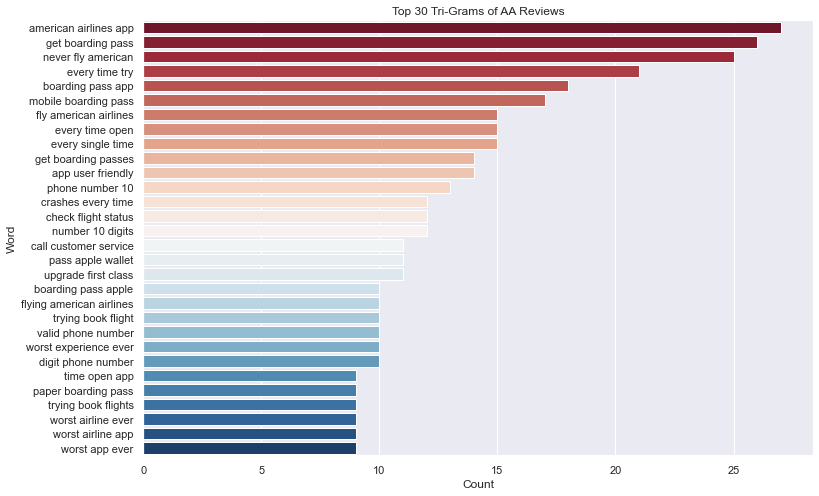

In [191]:
tri_gram_counts = tri_grams.most_common(30)

words = [' '.join(tup[0]) for tup in tri_gram_counts]
counts = [tup[1] for tup in tri_gram_counts]

plt.figure(figsize=(12,8))
g = sns.barplot(x=counts, y=words, palette='RdBu')
g.set_title('Top 30 Tri-Grams of AA Reviews')
g.set_xlabel('Count')
g.set_ylabel('Word')
plt.show(g)

We can immediately see some negative sentiments among these n-gram results. According to the tri-gram analysis results, it seems the app had some performance issues that customers ran into. It seems customers may have issues when attempting to access their boarding passes.

## Word2Vec & t-SNE

In [89]:
aa_df.head()

,username,review,isEdited,rating,title,date,review_length,month,year,year_month,tokenized_texts
0,marley_mae,I downloaded this app for my most recent trip ...,False,5,Very helpful!!,2021-08-28 19:20:58,1278,8,2021,2021-08,"[download, app, recent, trip, california, glad..."
1,slpoulos,The app is almost always very efficient.... bu...,False,5,Most things good but service reduction on flig...,2021-03-21 23:58:57,992,3,2021,2021-03,"[app, almost, alwai, effici, recent, seat, ass..."
2,eubanks6703,Flight 805 from Cancun to phl... April 5 238pm...,False,1,Horrible experience with VeriFLY,2021-04-06 00:24:56,1361,4,2021,2021-04,"[flight, 805, cancun, phl, april, 5, 238pm, ve..."
3,AnaKaluderovic,The worst air company. I am flying all the tim...,False,1,The worst airlines,2022-03-24 21:22:03,1333,3,2022,2022-03,"[worst, air, compani, fly, time, compani, made..."
4,Swooshn1,"Terrible app, this isn’t very functional comp...",False,5,Terrible app,2019-01-19 16:46:17,1031,1,2019,2019-01,"[terribl, app, function, compar, unit, app, dr..."


In [146]:
size = 1000
window = 5
min_count = 3
workers = -1
sg = 1 #CBOW

word2vec_model_file = 'word2vec_' + str(size) + '.model'

w2v_model = Word2Vec(tokenized_reviews, window=5, min_count=1, workers=4, sg=1)

w2v_model.save(word2vec_model_file)

In [147]:
w2v_model.train(tokenized_reviews, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)

(620097, 884715)

In [148]:
wv = w2v_model.wv

In [149]:
wv.most_similar('ipad')

[('iphone', 0.9702162146568298),
 ('latest', 0.9566078186035156),
 ('ios', 0.9465118646621704),
 ('version', 0.9382897615432739),
 ('13.', 0.9135915040969849),
 ('13', 0.9135347604751587),
 ('web', 0.9064477682113647),
 ('crashes', 0.9056218862533569),
 ('commonly', 0.9033025503158569),
 ('semi-permanently', 0.9017965793609619)]

In [150]:
total_vocabulary = set(word for tokenized_reviews in tokenized_reviews for word in tokenized_reviews)

In [179]:
vector_list = [w2v_model[word] for word in words if word in w2v_model.wv]

words_filtered = [word for word in words if word in w2v_model.wv]

word_vec_zip = zip(words_filtered, vector_list)

word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')

In [202]:
df.shape

(7418, 100)

In [199]:
tsne = TSNE(n_components = 2, init = 'random', random_state = 3, perplexity = 100)

tsne_df = tsne.fit_transform(df[:750])

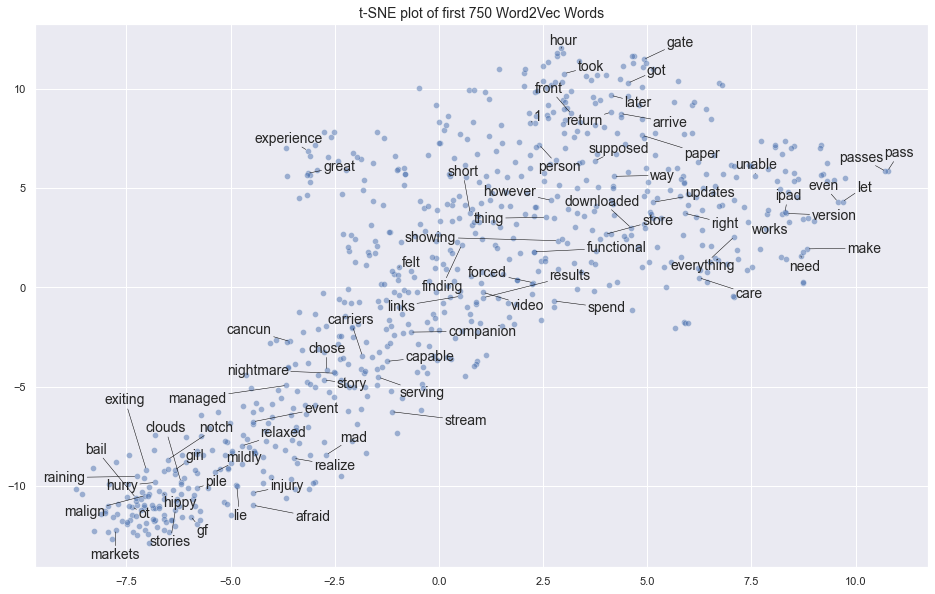

In [200]:
fig, ax = plt.subplots(figsize = (16, 10))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

texts = []
words_to_plot = list(np.arange(0, 750, 10))

for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
    
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.title("t-SNE plot of first 750 Word2Vec Words", fontsize=14)
plt.show()

With tSNE being primarily for exploratory purposes here, we can get a sense of what words cluster together when reduced down to 2 dimensions. The words 'great' and 'experience' seem to be separated from the other words in the plot.

We can infer some different types of topics from this, such as issues with the app coming in the top right, as well as something related to processing/waiting for flights near the top.

Now, can we identify certain topics within the data?

## LDA (Latent Dirichlet Analysis)

In [205]:
dictionary = Dictionary(tokenized_words)

In [206]:
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

In [208]:
corpus = [dictionary.doc2bow(doc) for doc in tokenized_words]

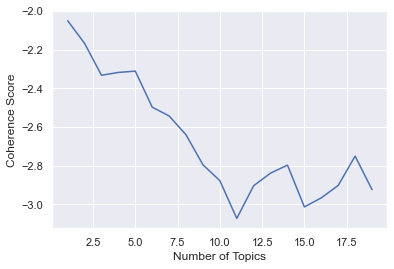

In [209]:
#u_mass coeherence score
topics = []
score = []

for i in range(1, 20):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=i, workers = 4, passes=10, random_state=3)
    co_model = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    
    topics.append(i)
    score.append(co_model.get_coherence())
    
plt.plot(topics, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

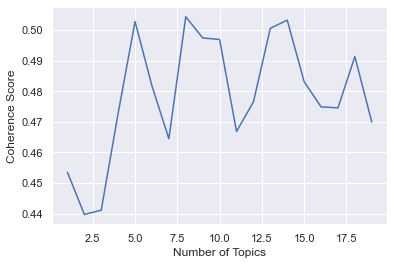

In [211]:
#c_v coherence score
topics = []
score = []

for i in range(1, 20):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=i, workers = 4, passes=10, random_state=3)
    co_model = CoherenceModel(model=lda_model, texts = tokenized_words, corpus=corpus, dictionary=dictionary, coherence='c_v')
    
    topics.append(i)
    score.append(co_model.get_coherence())
    
plt.plot(topics, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

Based on the coherence scores returned, I will make an LDA model using 5 topics.

In [212]:
TOPICS = 5
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=TOPICS, workers = 4, passes=100)

In [213]:
lda_model.print_topics()

[(0,
  '0.044*"flight" + 0.039*"american" + 0.039*"service" + 0.027*"airlines" + 0.026*"customer" + 0.019*"aa" + 0.018*"airline" + 0.014*"fly" + 0.014*"great" + 0.013*"experience"'),
 (1,
  '0.056*"flight" + 0.016*"get" + 0.013*"one" + 0.013*"flights" + 0.012*"hours" + 0.012*"us" + 0.012*"american" + 0.012*"plane" + 0.011*"time" + 0.011*"got"'),
 (2,
  '0.100*"app" + 0.018*"use" + 0.013*"airline" + 0.013*"aa" + 0.011*"american" + 0.010*"update" + 0.010*"like" + 0.010*"work" + 0.010*"flight" + 0.009*"would"'),
 (3,
  '0.037*"bags" + 0.036*"bag" + 0.027*"luggage" + 0.025*"baggage" + 0.017*"claim" + 0.015*"get" + 0.014*"credit" + 0.014*"minutes" + 0.013*"checked" + 0.013*"hour"'),
 (4,
  '0.082*"app" + 0.020*"boarding" + 0.017*"flight" + 0.016*"time" + 0.014*"get" + 0.013*"pass" + 0.012*"even" + 0.011*"check" + 0.010*"use" + 0.010*"flights"')]

In [214]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

With the 5 topics constructed, we obtain one topic that speaks positive sentiment about American Airlines and the app. The other 4 topics contain neutral to negative sentiments however. One topic discusses improvements the app needs to make, where there seems to be account and boarding pass errors. The topics in the bottom left of the chart reflect more so on airline performance, mentioning flight delays and issues with luggage and baggage claim.

We can save these topics for later if we wish to analyze them further:

In [234]:
aa_df['topic'] = [sorted(lda_model[corpus][text])[0][0] for text in range(len(aa_df['review']))]

In [235]:
aa_df

,username,review,isEdited,rating,title,date,review_length,year_month,topic
0,marley_mae,I downloaded this app for my most recent trip ...,False,5,Very helpful!!,2021-08-28 19:20:58,1278,2021-08,0
1,slpoulos,The app is almost always very efficient.... bu...,False,5,Most things good but service reduction on flig...,2021-03-21 23:58:57,992,2021-03,0
2,eubanks6703,Flight 805 from Cancun to phl... April 5 238pm...,False,1,Horrible experience with VeriFLY,2021-04-06 00:24:56,1361,2021-04,0
3,AnaKaluderovic,The worst air company. I am flying all the tim...,False,1,The worst airlines,2022-03-24 21:22:03,1333,2022-03,1
4,Swooshn1,"Terrible app, this isn’t very functional comp...",False,5,Terrible app,2019-01-19 16:46:17,1031,2019-01,0
...,...,...,...,...,...,...,...,...,...
3641,Spaz04,What a worthless app!!! The app itself is very...,False,1,Really!!!,2019-01-27 16:45:41,206,2019-01,0
3642,Bobby 1901,Very disappointed with how AA required a 200 m...,False,1,No notice of required update until at airport,2019-01-16 22:31:16,279,2019-01,1
3643,GC Jacob,The app sometimes works.It also freezes up a l...,False,2,Freezes,2019-01-15 01:57:14,237,2019-01,0
3644,Mom watcher,Very disappointed that American Airlines does ...,False,1,Does not work on older devices,2020-02-22 13:20:33,349,2020-02,0


In [236]:
aa_df['topic'].value_counts()

0    3014
1     349
2     195
4      49
3      39
Name: topic, dtype: int64

In [237]:
aa_df[aa_df['rating']<=2] #we could run all this again but just with only records with a bad rating.

,username,review,isEdited,rating,title,date,review_length,year_month,topic
2,eubanks6703,Flight 805 from Cancun to phl... April 5 238pm...,False,1,Horrible experience with VeriFLY,2021-04-06 00:24:56,1361,2021-04,0
3,AnaKaluderovic,The worst air company. I am flying all the tim...,False,1,The worst airlines,2022-03-24 21:22:03,1333,2022-03,1
6,samuel sicairos,Never flying AA again. I kept hearing all thes...,False,1,Worst flight experience ever,2021-07-18 22:38:43,1237,2021-07,1
8,L1011fivehundred,"The only thing worse than this app, is the fly...",False,1,Terrible App from a Horrible Airline,2021-08-04 17:04:14,1234,2021-08,0
10,Phileas Fogg's 'stache,"As AAdvantage member, I attempted to use this ...",False,1,Complete Lack of Support,2021-07-20 15:16:02,1181,2021-07,0
...,...,...,...,...,...,...,...,...,...
3641,Spaz04,What a worthless app!!! The app itself is very...,False,1,Really!!!,2019-01-27 16:45:41,206,2019-01,0
3642,Bobby 1901,Very disappointed with how AA required a 200 m...,False,1,No notice of required update until at airport,2019-01-16 22:31:16,279,2019-01,1
3643,GC Jacob,The app sometimes works.It also freezes up a l...,False,2,Freezes,2019-01-15 01:57:14,237,2019-01,0
3644,Mom watcher,Very disappointed that American Airlines does ...,False,1,Does not work on older devices,2020-02-22 13:20:33,349,2020-02,0


## Analyzing Reviews Rated 1-2

Since we have a lot of negative reviews pulled, why not analyze only reviews where users left a rating of either 1 or 2?

In [280]:
aa_df_low_rating = aa_df[aa_df['rating']<=2]

In [281]:
aa_df_low_rating.shape

(2637, 9)

In [282]:
aa_df_low_rating.head()

,username,review,isEdited,rating,title,date,review_length,year_month,topic
2,eubanks6703,Flight 805 from Cancun to phl... April 5 238pm...,False,1,Horrible experience with VeriFLY,2021-04-06 00:24:56,1361,2021-04,0
3,AnaKaluderovic,The worst air company. I am flying all the tim...,False,1,The worst airlines,2022-03-24 21:22:03,1333,2022-03,1
6,samuel sicairos,Never flying AA again. I kept hearing all thes...,False,1,Worst flight experience ever,2021-07-18 22:38:43,1237,2021-07,1
8,L1011fivehundred,"The only thing worse than this app, is the fly...",False,1,Terrible App from a Horrible Airline,2021-08-04 17:04:14,1234,2021-08,0
10,Phileas Fogg's 'stache,"As AAdvantage member, I attempted to use this ...",False,1,Complete Lack of Support,2021-07-20 15:16:02,1181,2021-07,0


In [283]:
tokenized_reviews = [nltk.word_tokenize(rev.lower()) for rev in aa_df_low_rating['review']]
tokenized_words = [[word for word in rev if word.isalnum() and word not in stop_words] for rev in tokenized_reviews]
words = np.concatenate(tokenized_words, axis=0)

In [317]:
tokenized_reviews = pd.Series(tokenized_reviews)

In [285]:
bi_grams = Counter(chain(*[nltk.ngrams(sentence, 2) for sentence in tokenized_words]))

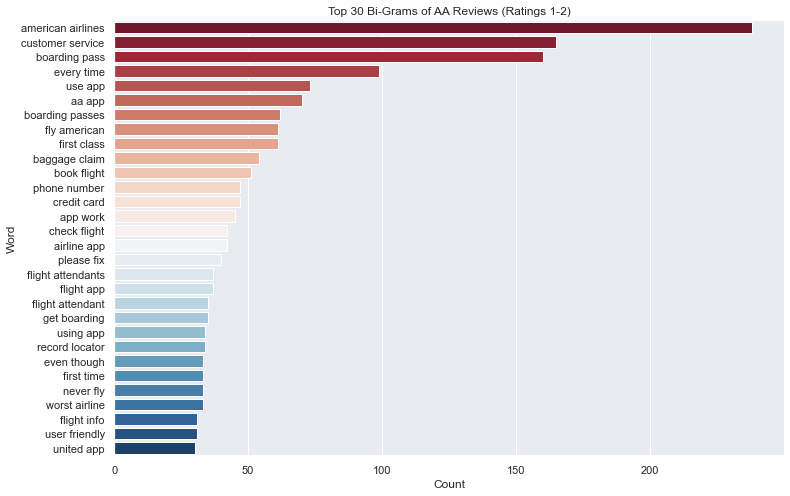

In [286]:
bi_gram_counts = bi_grams.most_common(30)

words = [' '.join(tup[0]) for tup in bi_gram_counts]
counts = [tup[1] for tup in bi_gram_counts]

plt.figure(figsize=(12,8))
g = sns.barplot(x=counts, y=words, palette='RdBu')
g.set_title('Top 30 Bi-Grams of AA Reviews (Ratings 1-2)')
g.set_xlabel('Count')
g.set_ylabel('Word')
plt.show(g)

In [287]:
tri_grams = Counter(chain(*[nltk.ngrams(sentence, 3) for sentence in tokenized_words]))

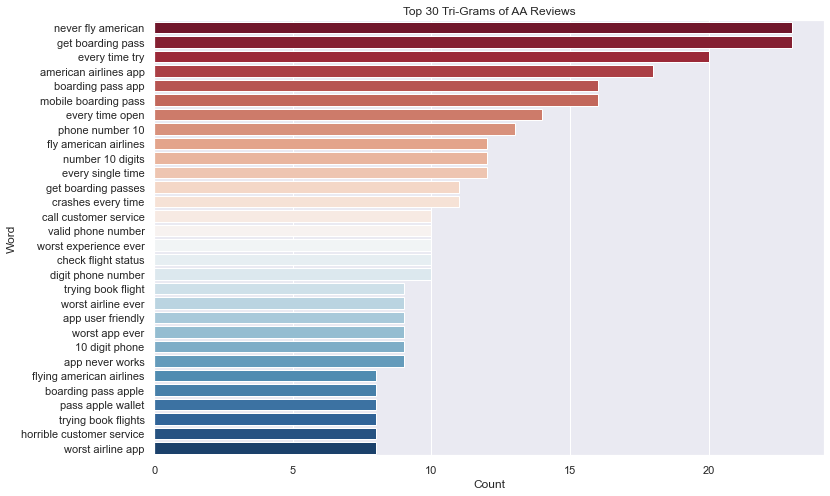

In [288]:
tri_gram_counts = tri_grams.most_common(30)

words = [' '.join(tup[0]) for tup in tri_gram_counts]
counts = [tup[1] for tup in tri_gram_counts]

plt.figure(figsize=(12,8))
g = sns.barplot(x=counts, y=words, palette='RdBu')
g.set_title('Top 30 Tri-Grams of AA Reviews')
g.set_xlabel('Count')
g.set_ylabel('Word')
plt.show(g)

Again we can see there seems to have been issues with boarding passes as well as the application's performance.

In [299]:
tokenized_reviews = [nltk.word_tokenize(rev.lower()) for rev in aa_df_low_rating['review']]
tokenized_words = [[word for word in rev if word.isalnum() and word not in stop_words] for rev in tokenized_reviews]
words = np.concatenate(tokenized_words, axis=0)

In [300]:
word2vec_model_file = 'word2vec_' + str(size) + '.model'

w2v_model = Word2Vec(tokenized_reviews, window=5, min_count=1, workers=4)

w2v_model.save(word2vec_model_file)

In [301]:
w2v_model.train(tokenized_reviews, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)

(479601, 684130)

In [304]:
total_vocabulary = set(word for tokenized_reviews in tokenized_reviews for word in tokenized_reviews)

In [305]:
vector_list = [w2v_model[word] for word in words if word in w2v_model.wv]

words_filtered = [word for word in words if word in w2v_model.wv]

word_vec_zip = zip(words_filtered, vector_list)

word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')

In [309]:
dictionary = Dictionary(tokenized_words)

dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

corpus = [dictionary.doc2bow(doc) for doc in tokenized_words]

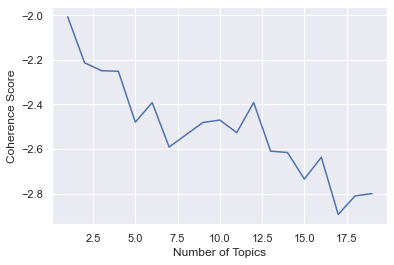

In [310]:
#u_mass coeherence score
topics = []
score = []

for i in range(1, 20):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=i, workers = 4, passes=10, random_state=3)
    co_model = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    
    topics.append(i)
    score.append(co_model.get_coherence())
    
plt.plot(topics, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

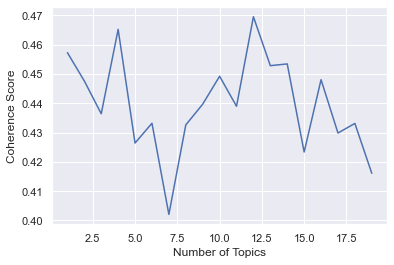

In [311]:
#c_v coherence score
topics = []
score = []

for i in range(1, 20):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=i, workers = 4, passes=10, random_state=3)
    co_model = CoherenceModel(model=lda_model, texts = tokenized_words, corpus=corpus, dictionary=dictionary, coherence='c_v')
    
    topics.append(i)
    score.append(co_model.get_coherence())
    
plt.plot(topics, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

In [314]:
TOPICS = 4
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=TOPICS, workers = 4, passes=100)

In [318]:
lda_model.print_topics()

[(0,
  '0.098*"app" + 0.014*"use" + 0.013*"update" + 0.013*"work" + 0.012*"time" + 0.012*"even" + 0.010*"phone" + 0.009*"log" + 0.008*"error" + 0.008*"get"'),
 (1,
  '0.048*"flight" + 0.014*"get" + 0.013*"bags" + 0.013*"time" + 0.013*"bag" + 0.011*"plane" + 0.011*"one" + 0.011*"hours" + 0.011*"american" + 0.011*"us"'),
 (2,
  '0.060*"app" + 0.032*"flight" + 0.027*"boarding" + 0.018*"check" + 0.017*"pass" + 0.017*"get" + 0.013*"flights" + 0.012*"time" + 0.010*"find" + 0.009*"information"'),
 (3,
  '0.049*"american" + 0.035*"airlines" + 0.035*"airline" + 0.028*"service" + 0.023*"customer" + 0.020*"app" + 0.017*"worst" + 0.017*"fly" + 0.016*"never" + 0.014*"experience"')]

In [316]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

From applying LDA, we get similar negative topics we obtained from applying it to the entire dataset. One topic revolves around users who had a general negative experience flying with American Airlines (top right component). The other three represent the performance of the mobile app, followed by issues with boarding passes/tickets and luggage.

Using the generated topics from LDA, we could analyze specific word influence that push words into one topic versus another.

In [320]:
aa_df['topic'].value_counts()

0    3014
1     349
2     195
4      49
3      39
Name: topic, dtype: int64

Since this topic relates to issues regarding the app in particular, it may be ideal to focus on this app in particular since while it is true we can still point out what customers are saying about the flight experience, we want to know how we can improve the mobile app since that is our focus here.

In [340]:
for i in aa_df[aa_df['topic']==2].index: #Topic index 2 relates to the topic of mobile app performance sentiments.
    print(aa_df.loc[i, 'review'])
    if i == 7: break

The aadvantage portion of the app works fine. However, the inflight entertainment is terrible.  Last week I was on a flight and used the app to launch the inflight movies.  While this is a little hit and miss (whether it works or not), this time it worked.  On my return flight, it decided that I needed to upgrade and it would not  let me launch the app without upgrading.  Keep in mind that I am on the plane when it notifies me of this.  You would think that it would let you upgrade while on the aa inflight wireless but no such luck.  So I tether to my phone while we are taxiing to attempt to upgrade to the latest version.  I successfully upgrade and launch the inflight movie selection only to be given an error 404 on my browser.  I tried several things including powering down my iPad to get it to work but it never did.  This is just one example of many where the inflight entertainment system did not work.  I am in support of using personal devices for inflight movies but only if the sy

In [342]:
aa_df.to_csv("aa_df_topics.csv")

## Closing Remarks:
* Looking at the raw data, we have imbalanced data as far as the amount of reviews we have for eaching rating (1-5), having many more 1 rated reviews.


* There is a dip in the amount of reviews written after the first quarter of 2020, which is very likely due to the COVID-19 pandemic where there was a lack of travel.


* Exploring the data using t-SNE, we could see a few clustered words that related to topics regarding flight performance such as delays, as well as the mobile app itself.


* With or without the positive sentiment reviews, we were able to find some prominent topics that related to the heavy abundance of the negative reviews we could scrape. These issues mainly revolved around luggage/baggage, boarding passes and ticketing, and the mobile app's general user experience and performance.


* With the extrpolated topics from LDA, we can investigate further into the words that distinguish these topics.

In the next notebook, we can apply a classifier to the reviews and attempt to find which words distinguish positive and negative sentiment.